# Portfolio Optimization using Monte Carlo Methods & PyPortfolioOpt

### Overview

This notebook employs Modern Portfolio Theory (MPT), Monte Carlo simulation, and PyPortfolioOpt optimization techniques to construct optimal investment portfolios from several randomly selected stocks. The period spans from January 2019 to December 2025.

### Methodology

1. **Data Collection & Processing**

    - Historical Price Data: Retrieved 7 years of daily adjusted close prices using yfinance API
    - Returns Calculation: Computed both simple and logarithmic returns for comprehensive analysis
    - Statistical Measures: Calculated annualized returns, volatility, correlation matrices, and covariance structures

2. **Monte Carlo Simulation**

    - Simulation Size: Generated 50,000 random portfolio combinations
    - Purpose: Map the efficient frontier by exploring diverse weight allocations across risk-return spectrum
    - Risk-Return Trade-off: Evaluated portfolio performance across different risk levels

3. **Dual Portfolio Optimization Approach**

   3.1 **Traditional Optimization (SciPy SLSQP)**
   
    - Objective Function: Maximize Sharpe Ratio through gradient-based optimization
    - Optimization Method: Sequential Least Squares Programming (SLSQP)
    - Constraints:
      - Portfolio weights sum to 100%
      - No short selling (weights between 0% and 100%)


   3.2 **Advanced Optimization (PyPortfolioOpt)**

    - Max Sharpe Ratio: Optimal risk-adjusted returns
    - Min Volatility: Conservative risk minimization
    - Efficient Risk: Target-volatility portfolio construction


### Risk Analysis

1. **Correlation Insights**
   
    - Diversification Benefits: The correlation matrix reveals varying relationships between stocks, enabling risk reduction through diversification
    - Sector Exposure: Mix of technology, retail, industrial, and financial sectors provides balanced exposure
    - Volatility Management: Portfolio volatility is lower than most individual stock volatilities due to diversification effects
  
2. **Efficient Frontier Visualization**
    
    - Risk-Return Spectrum: Clear trade-off between expected returns and volatility
    - Optimal Position: The optimized portfolio sits on the efficient frontier, offering maximum return for its risk level
    - Sharpe Ratio Gradient: Color-coded visualization shows risk-adjusted performance across all simulated portfolios

### Specifications

1. **Data & Methodology**
   
    - Analysis Period: January 2019 - December 2025
    - Trading Days: 252 days per year (annualization factor)
    - Optimization Algorithm: SLSQP (Sequential Least Squares Programming)
    - Monte Carlo Iterations: 50,000 simulations
    - Risk-Free Rate: 3.6% (used for Sharpe Ratio calculation)(1yr US treasury yield as of Dec 20 2025)
    - Data Source: Yahoo Finance via yfinance API
      

2. **Data & Methodology**

    - Monte Carlo Iterations: 50,000 simulations
    - SciPy Algorithm: SLSQP (Sequential Least Squares Programming)
    - PyPortfolioOpt Methods: Max Sharpe, Min Volatility, Efficient Risk
    - Constraints: Weights ∈ [0, 1], Σweights = 1 (no short selling, full investment)
    - Covariance Estimation: Sample covariance with 252-day annualization


3. **Performance Metrics**
    
    - Expected Return:  $\mu_{p} = \sum_{i=1}^{n} w_i \mu_i \times 252$
    - Portfolio Volatility: $\sigma_p = \sqrt{w^T \Sigma w \times 252}$
    - Sharpe Ratio: $SR = \frac{\mu_p - r_f}{\sigma_p}$
    - Discrete Allocation: Greedy algorithm maximizing portfolio value utilization



## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as optimization


In [2]:
import sys
import subprocess
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
    
try:
    import pypfopt
except ImportError:
    install('PyPortfolioOpt ')
    import pypfopt


# PyPortfolioOpt imports
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt import plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 7.0 MB/s eta 0:00:00


In [3]:

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Set consistent plotting style
sns.set_style('whitegrid')
plt.style.use('bmh')

# Plotting configuration
plt.rcParams['figure.figsize'] = (13.5, 7)
plt.rcParams['font.size'] = 10

# Set random seed for reproducibility
RANDOM_SEED = 3407
np.random.seed(RANDOM_SEED)

# Display settings
pd.set_option('display.precision', 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)


print(f" Random seed set to: {RANDOM_SEED}")

 Random seed set to: 3407


## 2. Data Collection and Preprocessing

*  the daily logarithmic returns: $$ R_i = log (r_{i}/r_{i-1}) $$

In [4]:
# Configuration
STOCKS = ['ADBE', 'BIIB', 'AEP', 'TPL', 'BALL', 'DASH', 'DUK', 'IFF', 'SO', 'TJX', 'UNH', 'AXON', 'JPM', 'MAR']
STOCKS = ['AEP', 'TPL', 'BALL', 'A', 'SO', 'TJX', 'UNH', 'AXON', 'JPM']
START_DATE = '2019-01-01'
END_DATE = '2026-01-01'
RISK_FREE_RATE = 0.036
NUM_PORTFOLIOS = 50_000
TRADING_DAYS = 252
PORTFOLIO_VALUE = 100000  # For discrete allocation

In [5]:
def download_stock_data(tickers, start_date, end_date):
    """
    Download historical stock data using yfinance
    
    Parameters:
    -----------
    tickers : list
        List of stock ticker symbols
    start_date : str
        Start date in format 'YYYY-MM-DD'
    end_date : str
        End date in format 'YYYY-MM-DD'
    
    Returns:
    --------
    tuple : (adjusted_close_data, complete_data)
    """
    try:
        # Download complete data
        complete_data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    
        if complete_data.empty:
            raise ValueError("No data downloaded. Check tickers and date range")
        
        if isinstance(complete_data.columns, pd.MultiIndex):
            adj_close_data = complete_data["Adj Close"] if "Adj Close" in complete_data.columns.get_level_values(0) else complete_data["Close"]
        else:
            adj_close_data = complete_data["Adj Close"] if "Adj Close" in complete_data.columns else complete_data["Close"]
        
        adj_close_data = adj_close_data.dropna(how="all", axis=0).dropna(how="all", axis=1)
        # adj_close_data.columns = tickers
            
        print(f'Successfully downloaded data for {len(tickers)} stocks')
        print(f'Date range: {adj_close_data.index[0].date()} to {adj_close_data.index[-1].date()}')
        print(f'Total trading days: {len(adj_close_data)}')
        
        return adj_close_data, complete_data
    
    except Exception as e:
        print(f'Error downloading data: {e}')
        return None, None

def calculate_returns(price_data):
    """
    Calculate daily and logarithmic returns from price data
    
    Parameters:
    -----------
    price_data : DataFrame
        DataFrame containing adjusted close prices
    
    Returns:
    --------
    tuple : (daily_returns, log_returns)
    """
    # Simple daily returns
    daily_returns = price_data.pct_change()
    
    # Logarithmic returns
    log_returns = np.log(price_data / price_data.shift(1))
    
    # Remove first row (NaN values)
    daily_returns = daily_returns.dropna()
    log_returns = log_returns.dropna()
    
    return daily_returns, log_returns

In [6]:
# Download data
print('Downloading stock data...')
print('=' * 60)
data, complete_data = download_stock_data(STOCKS, START_DATE, END_DATE)

# Calculate returns
daily_returns, log_returns = calculate_returns(data)

print('\n' + '=' * 60)
print('Data processing completed!')
print('=' * 60)

Successfully downloaded data for 9 stocks
Date range: 2019-01-02 to 2025-12-19
Total trading days: 1753

Data processing completed!


In [7]:
complete_data.head()

Price           Close                                                                                            \
Ticker              A        AEP       AXON       BALL        JPM         SO        TJX         TPL         UNH   
Date                                                                                                              
2019-01-02  62.553886  56.979641  45.110001  41.297977  81.616707  33.165642  40.638287  169.225220  217.128159   
2019-01-03  60.249416  56.846859  43.290001  40.918926  80.456779  33.635956  40.210602  169.709305  211.207062   
2019-01-04  62.334881  57.370239  46.009998  42.148521  83.422874  33.916634  41.311638  176.928696  213.677109   
2019-01-07  63.658520  57.049950  48.150002  42.934349  83.480858  33.840775  42.421776  185.238754  214.087280   
2019-01-08  64.591728  57.753021  49.410000  43.368870  83.323433  34.804188  43.049648  187.506760  216.949799   

Price            High                                                                                            \
Ticker              A        AEP       AXON       BALL        JPM         SO        TJX         TPL         UNH   
Date                                                                                                              
2019-01-02  63.391872  58.284219  45.119999  41.926646  82.002972  33.340118  40.984068  171.536563  219.678516   
2019-01-03  62.639584  57.542119  44.700001  41.630801  81.931529  33.901462  40.829367  172.819976  217.119245   
2019-01-04  62.801486  57.370239  46.209999  42.592287  83.621716  33.931806  41.584622  181.082230  217.101375   
2019-01-07  64.210832  57.190563  48.709999  43.563018  84.069101  33.954562  42.885851  188.557629  215.781568   
2019-01-08  64.953584  57.846766  49.910000  43.775654  84.359073  34.872461  43.167939  190.641327  218.287399   

Price             Low                                                                                            \
Ticker              A        AEP       AXON       BALL        JPM         SO        TJX         TPL         UNH   
Date                                                                                                              
2019-01-02  62.182506  56.612483  42.619999  41.048362  78.847118  32.816687  40.165113  156.848276  215.326853   
2019-01-03  59.040047  56.479707  42.419998  40.558367  80.108806  33.195971  39.855723  163.446120  210.565013   
2019-01-04  61.030283  56.448441  43.189999  41.316459  81.426158  33.408379  40.711072  172.356812  212.945895   
2019-01-07  62.477720  56.589053  46.389999  41.935878  82.610918  33.514580  41.238844  179.289331  212.437569   
2019-01-08  63.515671  56.784353  48.650002  43.193214  82.478354  33.757330  41.875814  186.764198  213.757405   

Price            Open                                                                                            \
Ticker              A        AEP       AXON       BALL        JPM         SO        TJX         TPL         UNH   
Date                                                                                                              
2019-01-02  63.325214  58.284219  42.990002  41.834196  78.855331  33.294601  40.247009  159.050558  218.474671   
2019-01-03  62.401520  56.979665  44.340000  41.076095  81.724401  33.195971  40.574582  167.336709  217.119245   
2019-01-04  61.030283  56.495310  43.950001  41.482871  82.113824  33.469064  40.774768  174.777215  213.837628   
2019-01-07  62.506287  56.979646  46.450001  42.176249  83.207447  33.764914  41.238844  179.289331  214.372628   
2019-01-08  64.363181  56.964023  48.980000  43.248682  84.201653  33.840776  42.585573  188.017727  216.093742   

Price        Volume                                                                           
Ticker            A      AEP     AXON     BALL       JPM       SO       TJX     TPL      UNH  
Date                                                                                          
2019-01-02  2113300  2679600  1

In [8]:
data.head()

Ticker,A,AEP,AXON,BALL,JPM,SO,TJX,TPL,UNH
Date,,,,,,,,,
2019-01-02,62.553886,56.979641,45.110001,41.297977,81.616707,33.165642,40.638287,169.225220,217.128159
2019-01-03,60.249416,56.846859,43.290001,40.918926,80.456779,33.635956,40.210602,169.709305,211.207062
2019-01-04,62.334881,57.370239,46.009998,42.148521,83.422874,33.916634,41.311638,176.928696,213.677109
2019-01-07,63.658520,57.049950,48.150002,42.934349,83.480858,33.840775,42.421776,185.238754,214.087280
2019-01-08,64.591728,57.753021,49.410000,43.368870,83.323433,34.804188,43.049648,187.506760,216.949799


In [9]:
log_returns.head()

Ticker,A,AEP,AXON,BALL,JPM,SO,TJX,TPL,UNH
Date,,,,,,,,,
2019-01-03,-0.037535,-0.002333,-0.041182,-0.009221,-0.014314,0.014081,-0.010580,0.002857,-0.027649
2019-01-04,0.034028,0.009165,0.060937,0.029607,0.036202,0.008310,0.027014,0.041660,0.011627
2019-01-07,0.021012,-0.005598,0.045462,0.018473,0.000695,-0.002239,0.026518,0.045899,0.001918
2019-01-08,0.014553,0.012248,0.025832,0.010070,-0.001888,0.028071,0.014692,0.012169,0.013282
2019-01-09,0.020719,-0.007603,0.017057,0.003830,-0.001692,-0.008537,-0.000846,-0.028580,0.001438


In [10]:
# Display basic statistics
print('\n' + '=' * 60)
print('BASIC STATISTICS - ADJUSTED CLOSE PRICES')
print('=' * 60)
print(data.describe())


BASIC STATISTICS - ADJUSTED CLOSE PRICES
Ticker            A          AEP         AXON         BALL          JPM           SO          TJX          TPL  \
count   1753.000000  1753.000000  1753.000000  1753.000000  1753.000000  1753.000000  1753.000000  1753.000000   
mean     117.061637    80.613336   238.034147    63.999894   150.216837    61.881266    77.812291   539.317601   
std       27.014402    13.407263   204.027421    13.241803    62.806234    15.637698    28.836211   334.332231   
min       60.249416    56.831104    43.290001    40.918926    67.407684    33.165642    34.134003    95.227608   
25%       96.890587    71.573708    93.220001    53.209583   105.164513    49.622463    55.825264   236.847382   
50%      123.645248    76.434212   170.899994    61.200497   133.229477    59.854012    65.787308   479.687073   
75%      136.761185    87.224770   289.209991    73.367134   183.131134    69.048294    95.208214   674.678589   
max      174.067612   123.769997   870.969971 

## 3. Data Visualization

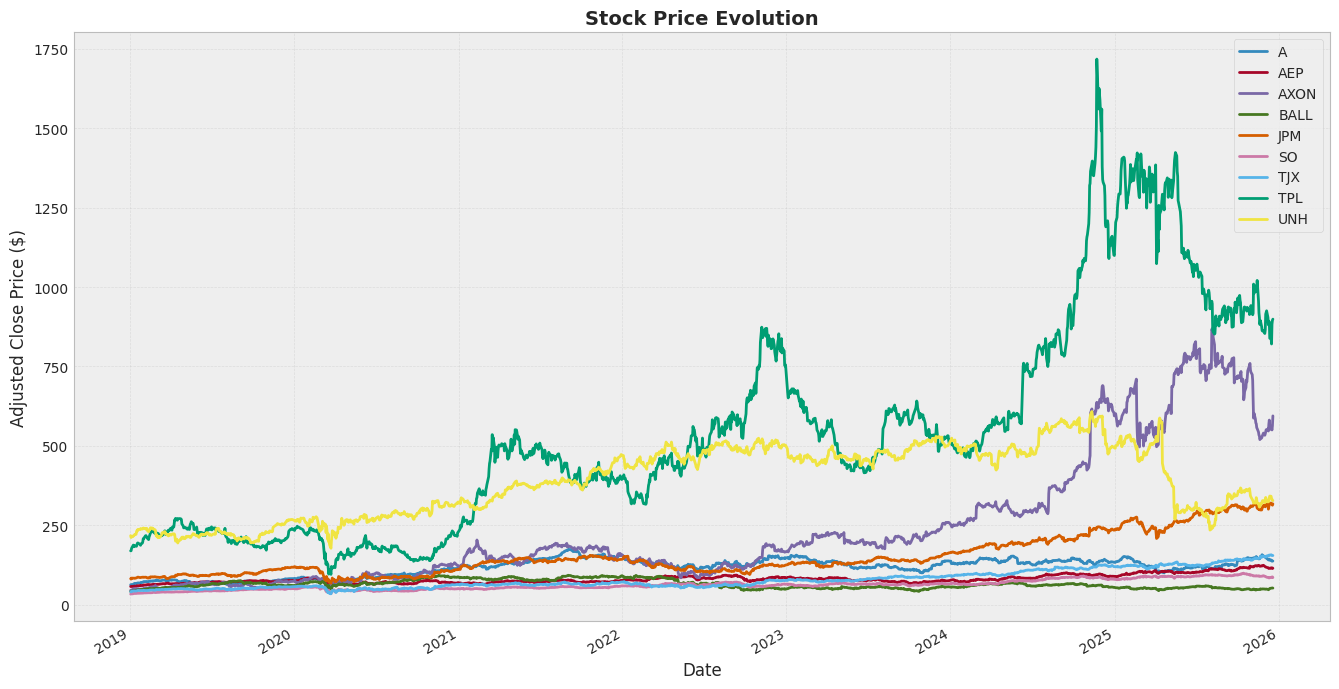

In [11]:
# Price evolution
data.plot()
plt.ylabel('Adjusted Close Price ($)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Stock Price Evolution', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

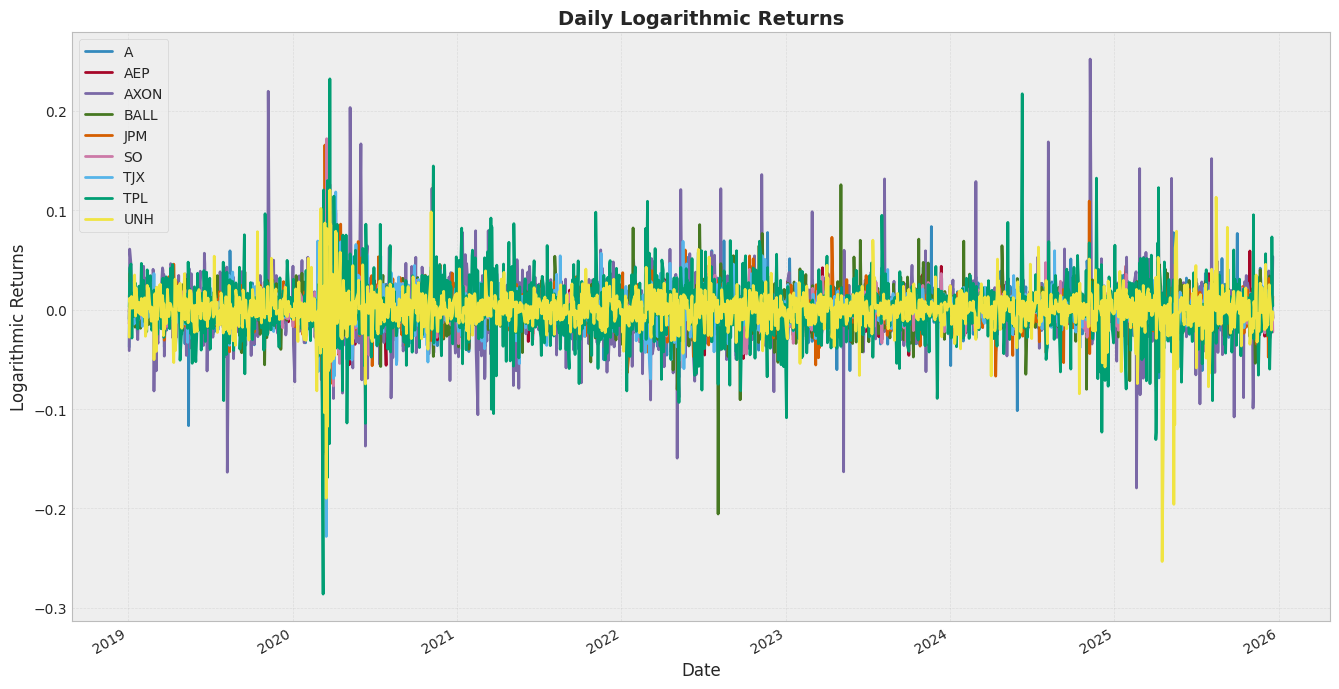

In [12]:
# Returns evolution
log_returns.plot()
plt.ylabel('Logarithmic Returns', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Daily Logarithmic Returns', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

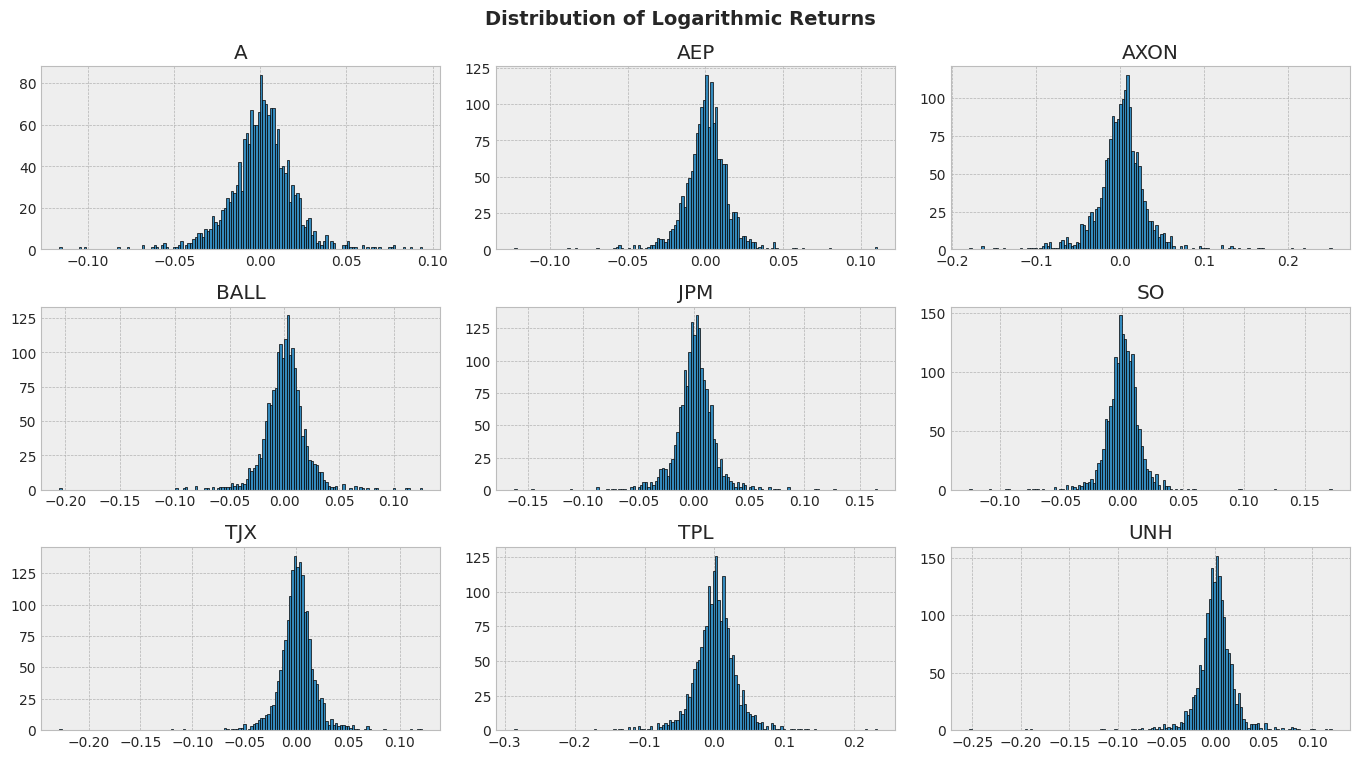

In [13]:
# Returns distribution
log_returns.hist(figsize=(13.7, 7.7), bins=150, edgecolor='black', linewidth=0.5)
plt.suptitle('Distribution of Logarithmic Returns', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Statistical Analysis


In [14]:
print('=' * 60)
print('ANNUALIZED RETURNS')
print('=' * 60)
annualized_returns = log_returns.mean() * TRADING_DAYS
for stock, ret in annualized_returns.items():
    print(f'{stock:6s}: {ret:7.2%}')

print('\n' + '=' * 60)
print('ANNUALIZED VOLATILITY')
print('=' * 60)
annualized_volatility = log_returns.std() * np.sqrt(TRADING_DAYS)
for stock, vol in annualized_volatility.items():
    print(f'{stock:6s}: {vol:7.2%}')

print('\n' + '=' * 60)
print('ANNUALIZED COVARIANCE MATRIX')
print('=' * 60)
print(log_returns.cov() * TRADING_DAYS)

ANNUALIZED RETURNS
A     :  11.30%
AEP   :  10.04%
AXON  :  37.08%
BALL  :   3.32%
JPM   :  19.53%
SO    :  13.58%
TJX   :  19.22%
TPL   :  24.02%
UNH   :   5.91%

ANNUALIZED VOLATILITY
A     :  29.32%
AEP   :  22.85%
AXON  :  49.22%
BALL  :  30.81%
JPM   :  29.88%
SO    :  23.97%
TJX   :  28.60%
TPL   :  49.82%
UNH   :  32.96%

ANNUALIZED COVARIANCE MATRIX
Ticker         A       AEP      AXON      BALL       JPM        SO       TJX       TPL       UNH
Ticker                                                                                          
A       0.085971  0.020719  0.046744  0.038316  0.039836  0.023911  0.033669  0.042090  0.030729
AEP     0.020719  0.052204  0.012310  0.027890  0.020711  0.044698  0.022571  0.012531  0.022409
AXON    0.046744  0.012310  0.242236  0.030756  0.045170  0.014808  0.041410  0.064452  0.025661
BALL    0.038316  0.027890  0.030756  0.094922  0.029059  0.031905  0.030748  0.023243  0.023181
JPM     0.039836  0.020711  0.045170  0.029059  0.089309  

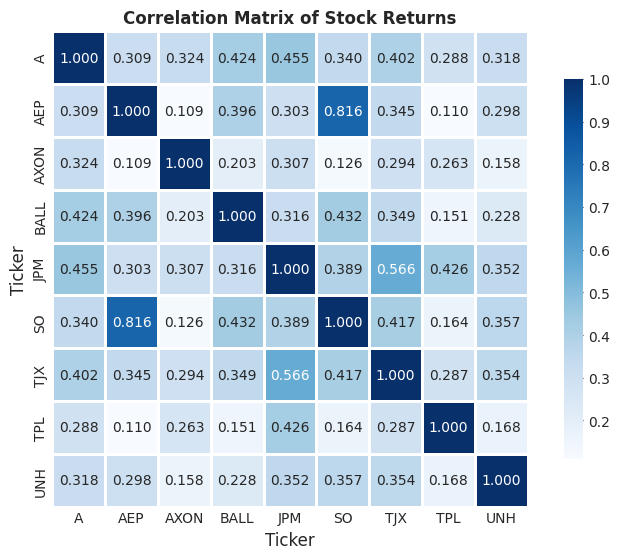

In [15]:
# Correlation heatmap
plt.figure(figsize=(7.7, 5.7))
sns.heatmap(log_returns.corr(), cmap='Blues', annot=True, fmt='.3f', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Stock Returns', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Portfolio Functions

In [16]:
def initialize_weights(num_stocks):
    """Generate random portfolio weights that sum to 1"""
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    return weights

def calculate_portfolio_return(returns, weights):
    """Calculate annualized portfolio return"""
    portfolio_return = np.sum(returns.mean() * weights) * TRADING_DAYS
    return portfolio_return

def calculate_portfolio_volatility(returns, weights):
    """Calculate annualized portfolio volatility (standard deviation)"""
    portfolio_volatility = np.sqrt(
        np.dot(weights.T, np.dot(returns.cov() * TRADING_DAYS, weights))
    )
    return portfolio_volatility

def calculate_sharpe_ratio(portfolio_return, portfolio_volatility, risk_free_rate=RISK_FREE_RATE):
    """Calculate Sharpe ratio"""
    return (portfolio_return - risk_free_rate) / portfolio_volatility

def portfolio_statistics(weights, returns):
    """Calculate portfolio return, volatility, and Sharpe ratio"""
    portfolio_return = calculate_portfolio_return(returns, weights)
    portfolio_volatility = calculate_portfolio_volatility(returns, weights)
    sharpe_ratio = calculate_sharpe_ratio(portfolio_return, portfolio_volatility)
    return np.array([portfolio_return, portfolio_volatility, sharpe_ratio])

### Test Single Portfolio

In [17]:
test_weights = initialize_weights(len(STOCKS))
print('Random Weights:', test_weights.round(3))
print('Expected Portfolio Return:', calculate_portfolio_return(log_returns, test_weights).round(4))
print('Expected Portfolio Volatility:', calculate_portfolio_volatility(log_returns, test_weights).round(4))

Random Weights: [0.068 0.139 0.02  0.158 0.123 0.163 0.131 0.184 0.014]
Expected Portfolio Return: 0.1506
Expected Portfolio Volatility: 0.2087


## 6. Monte Carlo Simulation

In [18]:
def generate_portfolios(returns, num_portfolios=NUM_PORTFOLIOS):
    """
    Generate random portfolios using Monte Carlo simulation
    Returns arrays of portfolio returns and volatilities
    """
    num_stocks = len(returns.columns)
    portfolio_returns = np.zeros(num_portfolios)
    portfolio_volatilities = np.zeros(num_portfolios)
    
    for i in range(num_portfolios):
        weights = initialize_weights(num_stocks)
        portfolio_returns[i] = calculate_portfolio_return(returns, weights)
        portfolio_volatilities[i] = calculate_portfolio_volatility(returns, weights)
    
    return portfolio_returns, portfolio_volatilities


In [19]:
def plot_efficient_frontier(returns, volatilities, optimum_stats=None, pypfopt_stats=None):
    """Plot the efficient frontier with optional optimum portfolios"""
    sharpe_ratios = (returns - RISK_FREE_RATE) / volatilities
    
    plt.figure()
    scatter = plt.scatter(volatilities, returns, c=sharpe_ratios, 
                         marker='o', alpha=0.6, cmap='viridis')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Expected Volatility (Risk)', fontsize=12)
    plt.ylabel('Expected Return', fontsize=12)
    plt.title('Efficient Frontier - Monte Carlo Simulation', fontsize=14, fontweight='bold')
    colorbar = plt.colorbar(scatter, label='Sharpe Ratio')
    
    # Plot scipy optimal portfolio if provided
    if optimum_stats is not None:
        plt.scatter(optimum_stats[1], optimum_stats[0], 
                   c='red', marker='*', s=500, edgecolors='black', 
                   linewidths=2, label='Optimal (SciPy)', zorder=5)
    
    # Plot PyPortfolioOpt optimal portfolio if provided
    if pypfopt_stats is not None:
        plt.scatter(pypfopt_stats[1], pypfopt_stats[0], 
                   c='lime', marker='D', s=300, edgecolors='black', 
                   linewidths=2, label='Optimal (PyPortfolioOpt)', zorder=5)
    
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()


In [20]:
# Generate portfolios
print(f'Generating {NUM_PORTFOLIOS:,} random portfolios...')
portfolio_returns, portfolio_volatilities = generate_portfolios(log_returns)
print('Monte Carlo simulation completed!')

Generating 50,000 random portfolios...
Monte Carlo simulation completed!


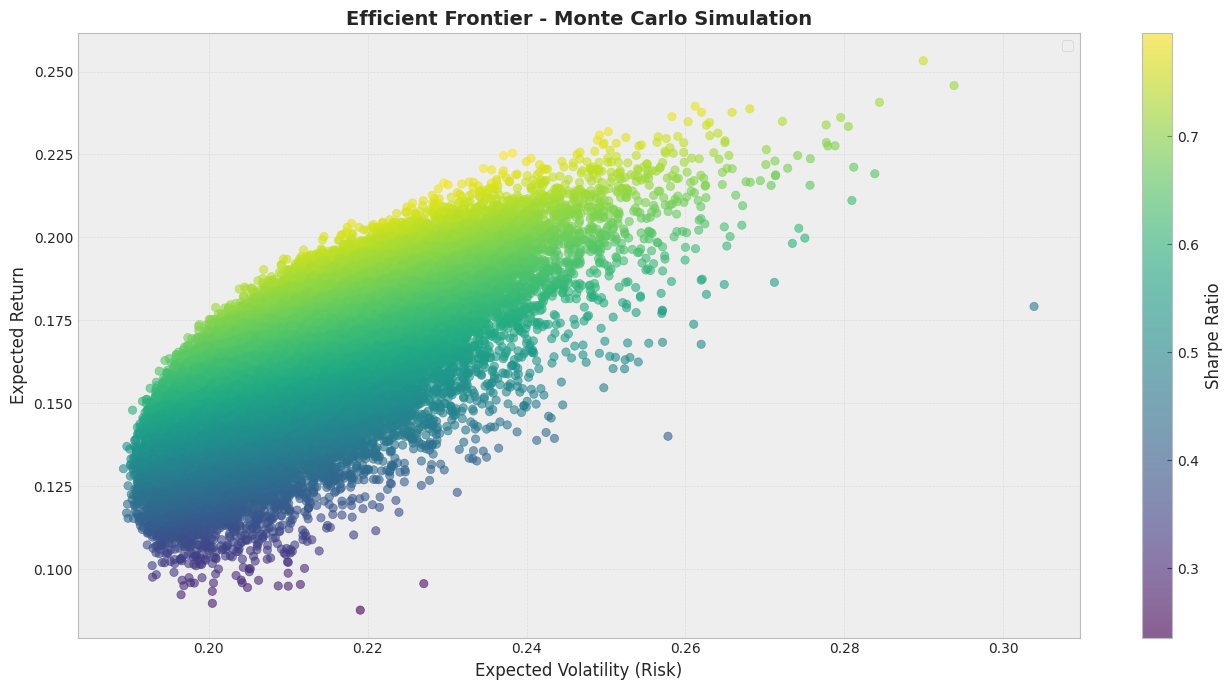

In [21]:
# Plot initial efficient frontier
plot_efficient_frontier(portfolio_returns, portfolio_volatilities)

## 7. Portfolio Optimization 

### 7.1 Portfolio Optimization - SciPy Approach

In [22]:
def negative_sharpe_ratio(weights, returns):
    """Objective function to minimize (negative Sharpe ratio)"""
    return -portfolio_statistics(weights, returns)[2]

def optimize_portfolio(returns):
    """
    Optimize portfolio to maximize Sharpe ratio
    Returns optimization result
    """
    num_stocks = len(returns.columns)
    initial_weights = initialize_weights(num_stocks)
    
    # Constraints: weights sum to 1
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # Bounds: each weight between 0 and 1
    bounds = tuple((0, 1) for _ in range(num_stocks))
    
    # Optimization
    result = optimization.minimize(
        fun=negative_sharpe_ratio,
        x0=initial_weights,
        args=(returns,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return result

In [23]:
# Optimize portfolio
print('OPTIMIZING PORTFOLIO USING SCIPY...')
optimum = optimize_portfolio(log_returns)

if optimum.success:
    print('Optimization successful!')
else:
    print('Optimization warning:', optimum.message)

OPTIMIZING PORTFOLIO USING SCIPY...
Optimization successful!


### 7.2 Portfolio Optimization - PyPortfolioOpt

In [24]:
def optimize_portfolio_pypfopt(price_data, method='max_sharpe'):
    """
    Optimize portfolio using PyPortfolioOpt library
    
    Parameters:
    -----------
    price_data : DataFrame
        Historical price data
    method : str
        Optimization method: 'max_sharpe', 'min_volatility', or 'efficient_risk'
    
    Returns:
    --------
    dict : Optimization results including weights and performance
    """
    # Calculate expected returns and covariance matrix
    mu = expected_returns.mean_historical_return(price_data)
    S = risk_models.sample_cov(price_data)
    
    # Initialize Efficient Frontier
    ef = EfficientFrontier(mu, S)
    
    # Optimize based on method
    if method == 'max_sharpe':
        weights = ef.max_sharpe(risk_free_rate=RISK_FREE_RATE)
        print('\nOptimization Method: Maximum Sharpe Ratio')
    elif method == 'min_volatility':
        weights = ef.min_volatility()
        print('\nOptimization Method: Minimum Volatility')
    elif method == 'efficient_risk':
        weights = ef.efficient_risk(target_volatility=0.20)
        print('\nOptimization Method: Efficient Risk (Target Volatility = 20%)')
    
    # Clean weights (remove very small weights)
    cleaned_weights = ef.clean_weights()
    
    # Get portfolio performance
    performance = ef.portfolio_performance(verbose=True, risk_free_rate=RISK_FREE_RATE)
    
    return {
        'weights': cleaned_weights,
        'raw_weights': weights,
        'expected_return': performance[0],
        'volatility': performance[1],
        'sharpe_ratio': performance[2],
        'ef_object': ef
    }

In [25]:
# Optimize using PyPortfolioOpt - Maximum Sharpe Ratio
print('=' * 60)
print('OPTIMIZING PORTFOLIO USING PYPFOPT (MAX SHARPE)...')
print('=' * 60)
pypfopt_max_sharpe = optimize_portfolio_pypfopt(data, method='max_sharpe')

OPTIMIZING PORTFOLIO USING PYPFOPT (MAX SHARPE)...

Optimization Method: Maximum Sharpe Ratio
Expected annual return: 28.6%
Annual volatility: 26.0%
Sharpe Ratio: 0.96


In [26]:
# Optimize using PyPortfolioOpt - Minimum Volatility
print('\n' + '=' * 60)
print('OPTIMIZING PORTFOLIO USING PYPFOPT (MIN VOLATILITY)...')
print('=' * 60)
pypfopt_min_vol = optimize_portfolio_pypfopt(data, method='min_volatility')


OPTIMIZING PORTFOLIO USING PYPFOPT (MIN VOLATILITY)...

Optimization Method: Minimum Volatility
Expected annual return: 13.4%
Annual volatility: 18.7%
Sharpe Ratio: 0.52


### 7.3 Portfolio Optimization - PyPortfolioOpt Discrete Allocation

In [27]:
def calculate_discrete_allocation(weights_dict, price_data, portfolio_value=PORTFOLIO_VALUE):
    """
    Calculate discrete allocation (actual number of shares to buy)
    
    Parameters:
    -----------
    weights_dict : dict
        Portfolio weights
    price_data : DataFrame
        Historical price data
    portfolio_value : float
        Total portfolio value in dollars
    
    Returns:
    --------
    dict : Allocation details
    """
    latest_prices = get_latest_prices(price_data)
    
    da = DiscreteAllocation(weights_dict, latest_prices, total_portfolio_value=portfolio_value)
    allocation, leftover = da.greedy_portfolio()
    
    return {
        'allocation': allocation,
        'leftover': leftover,
        'latest_prices': latest_prices
    }

In [28]:
# Calculate discrete allocation for max Sharpe portfolio
print('=' * 60)
print(f'DISCRETE ALLOCATION (Portfolio Value: ${PORTFOLIO_VALUE:,.0f})')
print('=' * 60)
discrete_alloc = calculate_discrete_allocation(pypfopt_max_sharpe['weights'], data)

print('\nNumber of shares to purchase:')
for stock, shares in discrete_alloc['allocation'].items():
    price = discrete_alloc['latest_prices'][stock]
    value = shares * price
    print(f'{stock:6s}: {shares:4d} shares @ ${price:7.2f} = ${value:10,.2f}')

print(f'\nFunds remaining: ${discrete_alloc["leftover"]:,.2f}')

DISCRETE ALLOCATION (Portfolio Value: $100,000)

Number of shares to purchase:
AXON  :   60 shares @ $ 594.20 = $ 35,652.00
SO    :  268 shares @ $  85.28 = $ 22,855.04
TJX   :  138 shares @ $ 154.60 = $ 21,334.80
JPM   :   38 shares @ $ 317.21 = $ 12,053.98
TPL   :    9 shares @ $ 898.86 = $  8,089.74

Funds remaining: $14.44


## 8. Optimal Portfolio Results

### 8.1 Optimal Portfolio Results - SciPy Approach

In [29]:
def display_optimal_portfolio(optimum, returns, stocks=STOCKS):
    """Display optimal portfolio weights and statistics"""
    optimal_weights = optimum.x
    stats = portfolio_statistics(optimal_weights, returns)
    
    print('\n' + '=' * 60)
    print('OPTIMAL PORTFOLIO ALLOCATION')
    print('=' * 60)
    
    for i, stock in enumerate(stocks):
        print(f'{stock:6s}: {optimal_weights[i]:7.2%}')
    
    print('\n' + '=' * 60)
    print('PORTFOLIO PERFORMANCE METRICS')
    print('=' * 60)
    print(f'Expected Annual Return:     {stats[0]:7.2%}')
    print(f'Expected Annual Volatility: {stats[1]:7.2%}')
    print(f'Sharpe Ratio:               {stats[2]:7.3f}')
    print('=' * 60 + '\n')
    
    return optimal_weights, stats

In [30]:
scipy_weights, scipy_stats = display_optimal_portfolio(optimum, log_returns)


OPTIMAL PORTFOLIO ALLOCATION
AEP   :   0.00%
TPL   :   0.00%
BALL  :  32.54%
A     :   0.00%
SO    :  12.93%
TJX   :  25.04%
UNH   :  21.62%
AXON  :   7.88%
JPM   :   0.00%

PORTFOLIO PERFORMANCE METRICS
Expected Annual Return:      24.04%
Expected Annual Volatility:  25.00%
Sharpe Ratio:                 0.817



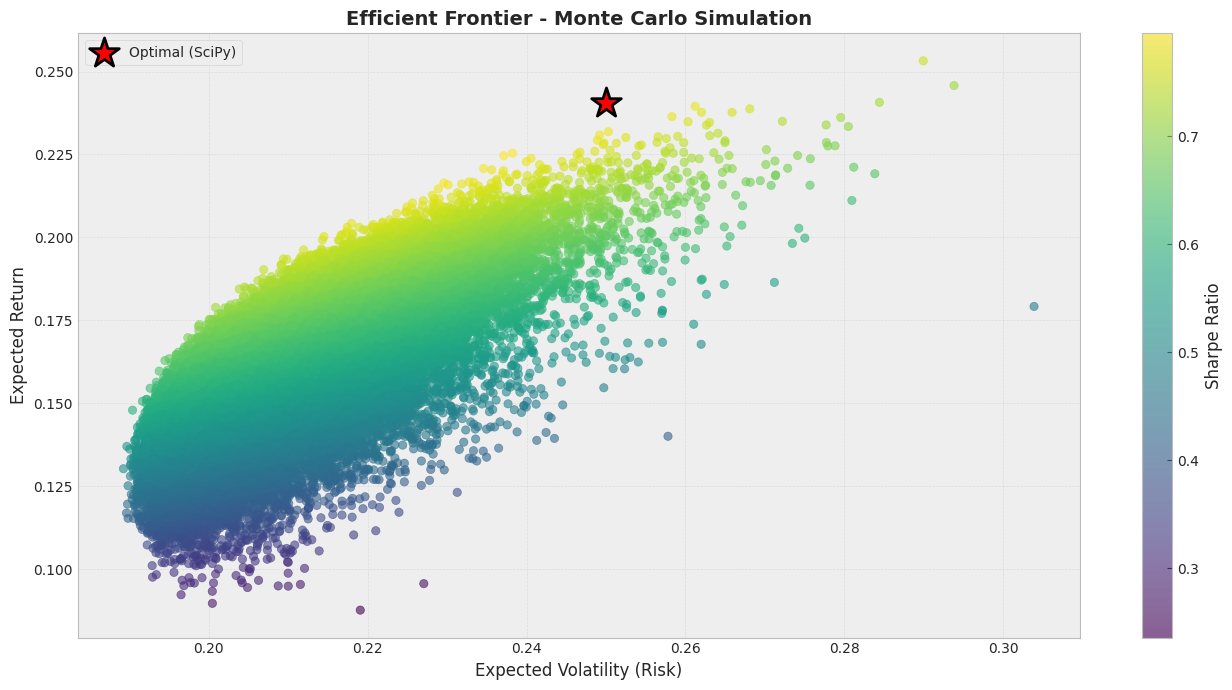

In [31]:
# Plot efficient frontier with optimal portfolio
plot_efficient_frontier(portfolio_returns, portfolio_volatilities, scipy_stats)

### 8.2 Optimal Portfolio Results - PyPortfolioOpt

In [32]:

def display_pypfopt_portfolio(pypfopt_result, method_name='PyPortfolioOpt'):
    """Display PyPortfolioOpt portfolio weights and statistics"""
    print('\n' + '=' * 60)
    print(f'OPTIMAL PORTFOLIO ALLOCATION ({method_name})')
    print('=' * 60)
    
    for stock, weight in pypfopt_result['weights'].items():
        if weight > 0:
            print(f'{stock:6s}: {weight:7.2%}')
    
    print('\n' + '=' * 60)
    print('PORTFOLIO PERFORMANCE METRICS')
    print('=' * 60)
    print(f'Expected Annual Return:     {pypfopt_result["expected_return"]:7.2%}')
    print(f'Expected Annual Volatility: {pypfopt_result["volatility"]:7.2%}')
    print(f'Sharpe Ratio:               {pypfopt_result["sharpe_ratio"]:7.3f}')
    print('=' * 60 + '\n')
    
    return pypfopt_result['weights'], np.array([
        pypfopt_result['expected_return'],
        pypfopt_result['volatility'],
        pypfopt_result['sharpe_ratio']
    ])

In [33]:
# Display PyPortfolioOpt Max Sharpe results
pypfopt_weights, pypfopt_stats = display_pypfopt_portfolio(pypfopt_max_sharpe, method_name='PyPortfolioOpt Max Sharpe')


OPTIMAL PORTFOLIO ALLOCATION (PyPortfolioOpt Max Sharpe)
AXON  :  35.60%
JPM   :  12.12%
SO    :  22.94%
TJX   :  21.45%
TPL   :   7.89%

PORTFOLIO PERFORMANCE METRICS
Expected Annual Return:      28.62%
Expected Annual Volatility:  25.95%
Sharpe Ratio:                 0.964



In [34]:
# Display PyPortfolioOpt Min Volatility results
pypfopt_minvol_weights, pypfopt_minvol_stats = display_pypfopt_portfolio(pypfopt_min_vol, method_name='PyPortfolioOpt Min Volatility')


OPTIMAL PORTFOLIO ALLOCATION (PyPortfolioOpt Min Volatility)
A     :  10.83%
AEP   :  42.30%
AXON  :   3.72%
BALL  :   9.10%
JPM   :   6.33%
SO    :   1.97%
TJX   :  10.98%
TPL   :   3.60%
UNH   :  11.18%

PORTFOLIO PERFORMANCE METRICS
Expected Annual Return:      13.37%
Expected Annual Volatility:  18.68%
Sharpe Ratio:                 0.523



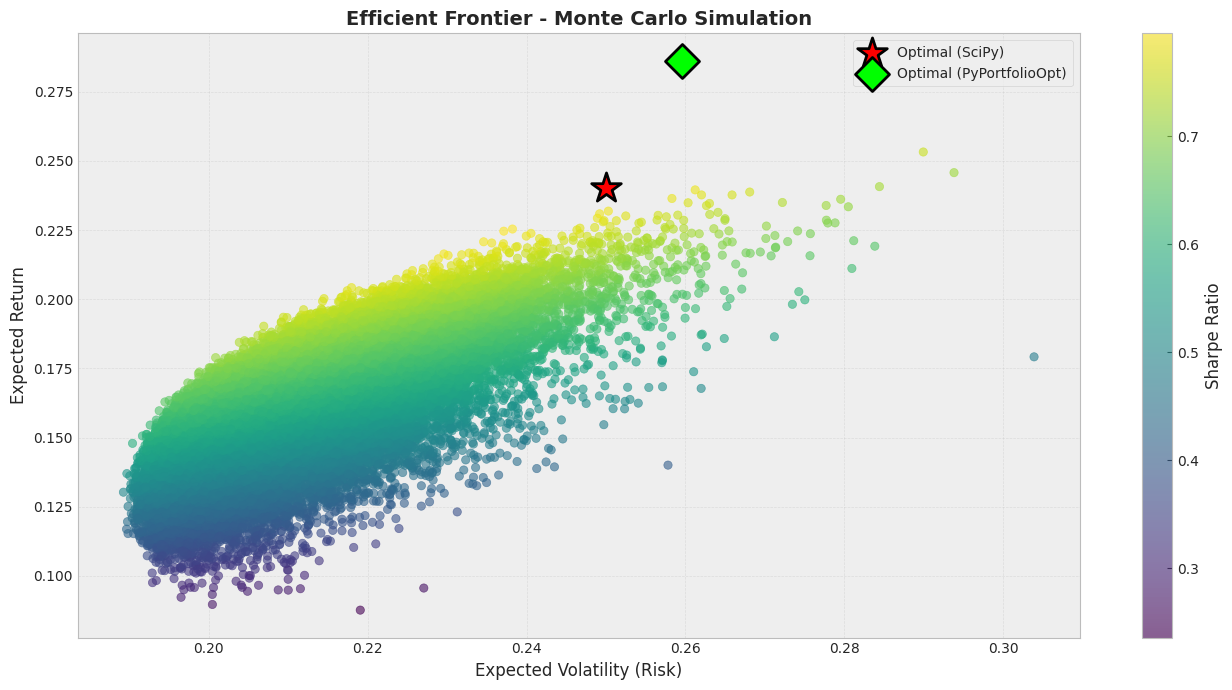

In [35]:
# Plot efficient frontier with both optimal portfolios
plot_efficient_frontier(portfolio_returns, portfolio_volatilities, scipy_stats, pypfopt_stats)

### 8.3 Comparison of Optimization Methods

In [36]:
def create_comparison_table(scipy_stats, pypfopt_stats, pypfopt_minvol_stats):
    """Create comparison table of different optimization methods"""
    comparison_data = {
        'Method': ['SciPy SLSQP', 'PyPortfolioOpt (Max Sharpe)', 'PyPortfolioOpt (Min Volatility)'],
        'Expected Return': [scipy_stats[0], pypfopt_stats[0], pypfopt_minvol_stats[0]],
        'Volatility': [scipy_stats[1], pypfopt_stats[1], pypfopt_minvol_stats[1]],
        'Sharpe Ratio': [scipy_stats[2], pypfopt_stats[2], pypfopt_minvol_stats[2]]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    
    return comparison_df

In [37]:
comparison_table = create_comparison_table(scipy_stats, pypfopt_stats, pypfopt_minvol_stats)
print('\n' + '=' * 80)
print('COMPARISON OF OPTIMIZATION METHODS')
print('=' * 80)
print(comparison_table.to_string(index=False))
print('=' * 80)


COMPARISON OF OPTIMIZATION METHODS
                         Method  Expected Return  Volatility  Sharpe Ratio
                    SciPy SLSQP         0.240377    0.250009      0.817477
    PyPortfolioOpt (Max Sharpe)         0.286200    0.259526      0.964064
PyPortfolioOpt (Min Volatility)         0.133719    0.186791      0.523145


## 9. Portfolio Weights Visualization

### 9.1 Portfolio Weights - SciPy Approach

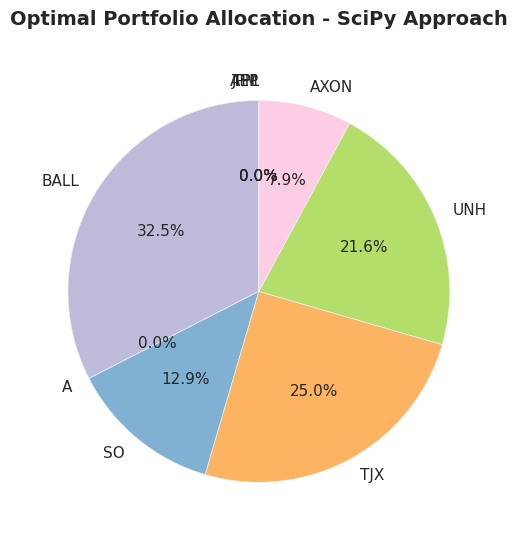

In [38]:
# Pie chart of optimal weights
plt.figure(figsize=(7.7, 5.5))
colors = plt.cm.Set3(range(len(STOCKS)))
wedges, texts, autotexts = plt.pie(scipy_weights, labels=STOCKS, autopct='%1.1f%%', 
                                     startangle=90, colors=colors, textprops={'fontsize': 11})
plt.title('Optimal Portfolio Allocation - SciPy Approach', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

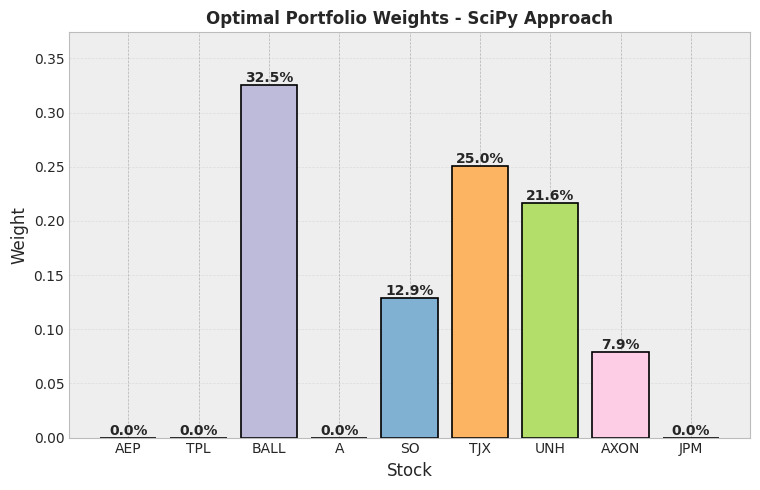

In [39]:
# Bar chart of optimal weights
plt.figure(figsize=(7.7, 5))
bars = plt.bar(STOCKS, scipy_weights, color=colors, edgecolor='black', linewidth=1.2)
plt.ylabel('Weight', fontsize=12)
plt.xlabel('Stock', fontsize=12)
plt.title('Optimal Portfolio Weights - SciPy Approach', fontsize=12, fontweight='bold')
plt.ylim(0, max(scipy_weights) * 1.15)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 9.2 Portfolio Weights - PyPortfolioOpt

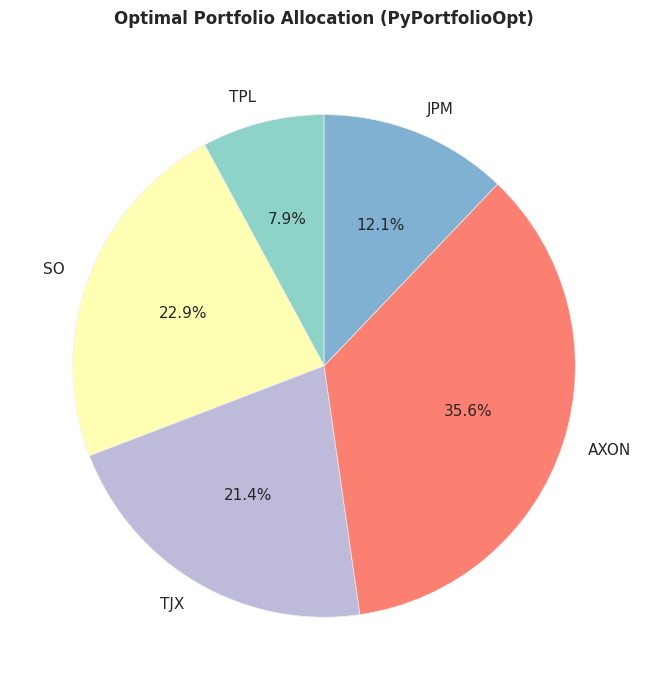

In [40]:
# Pie chart of PyPortfolioOpt optimal weights
plt.figure()
pypfopt_weights_array = np.array([pypfopt_weights.get(stock, 0) for stock in STOCKS])
non_zero_mask = pypfopt_weights_array > 0.001
filtered_stocks = [stock for stock, include in zip(STOCKS, non_zero_mask) if include]
filtered_weights = pypfopt_weights_array[non_zero_mask]

colors = plt.cm.Set3(range(len(filtered_stocks)))
wedges, texts, autotexts = plt.pie(filtered_weights, labels=filtered_stocks, autopct='%1.1f%%', 
                                     startangle=90, colors=colors, textprops={'fontsize': 11})
plt.title('Optimal Portfolio Allocation (PyPortfolioOpt)', fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### 9.2 Efficient Frontier Curve (PyPortfolioOpt)

In [41]:
def plot_pypfopt_efficient_frontier(price_data):
    """Plot the efficient frontier using PyPortfolioOpt"""
    mu = expected_returns.mean_historical_return(price_data)
    S = risk_models.sample_cov(price_data)
    
    ef = EfficientFrontier(mu, S)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
    
    # Find and plot the max Sharpe portfolio
    ef_max_sharpe = EfficientFrontier(mu, S)
    ef_max_sharpe.max_sharpe(risk_free_rate=RISK_FREE_RATE)
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance(risk_free_rate=RISK_FREE_RATE)
    ax.scatter(std_tangent, ret_tangent, marker='*', s=500, c='red', 
              edgecolors='black', linewidths=2, label='Max Sharpe', zorder=5)
    
    # Find and plot the min volatility portfolio
    ef_min_vol = EfficientFrontier(mu, S)
    ef_min_vol.min_volatility()
    ret_min_vol, std_min_vol, _ = ef_min_vol.portfolio_performance(risk_free_rate=RISK_FREE_RATE)
    ax.scatter(std_min_vol, ret_min_vol, marker='D', s=300, c='lime', 
              edgecolors='black', linewidths=2, label='Min Volatility', zorder=5)
    
    ax.set_title('Efficient Frontier (PyPortfolioOpt)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

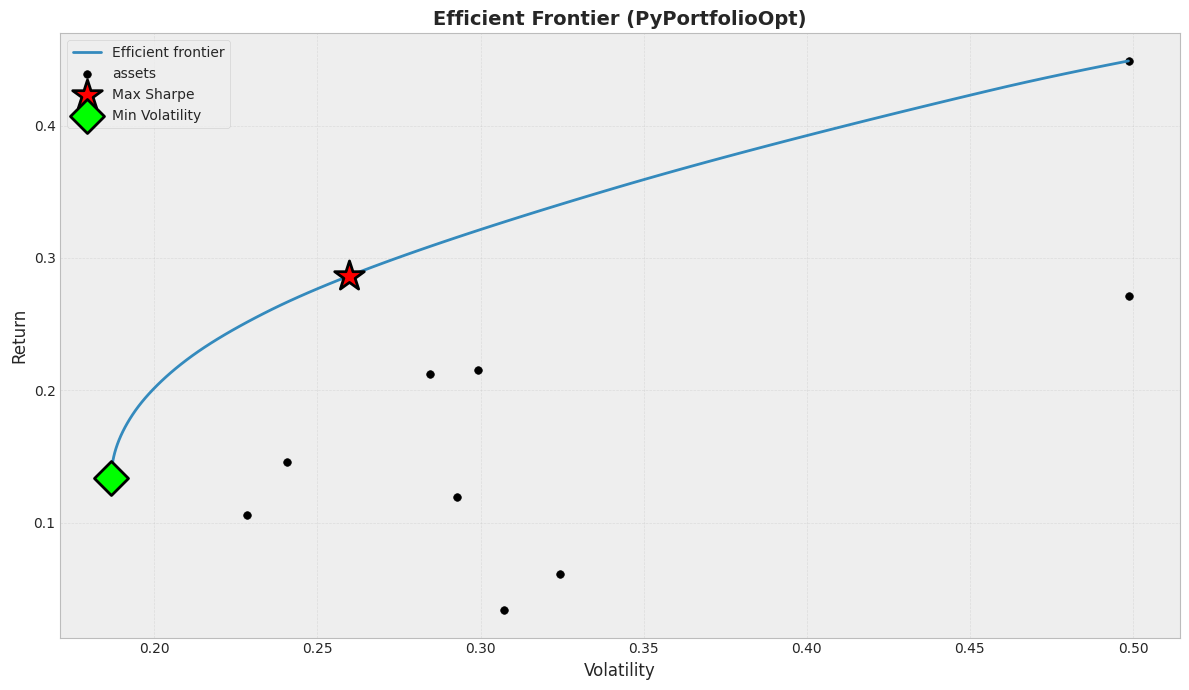

In [42]:
plot_pypfopt_efficient_frontier(data)

### 9.3 Portfolio Weights Comparison: SciPy vs PyPortfolioOpt

In [43]:
# Compare weights across methods
def plot_weights_comparison(scipy_weights, pypfopt_weights, stocks=STOCKS):
    """Plot comparison of weights from different optimization methods"""
    # Convert pypfopt weights dict to array
    pypfopt_weights_array = np.array([pypfopt_weights.get(stock, 0) for stock in stocks])
    
    x = np.arange(len(stocks))
    width = 0.35
    
    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width/2, scipy_weights, width, label='SciPy', 
                   color='steelblue', edgecolor='black', linewidth=1.2)
    bars2 = ax.bar(x + width/2, pypfopt_weights_array, width, label='PyPortfolioOpt', 
                   color='lightcoral', edgecolor='black', linewidth=1.2)
    
    ax.set_ylabel('Weight', fontsize=12)
    ax.set_xlabel('Stock', fontsize=12)
    ax.set_title('Portfolio Weights Comparison: SciPy vs PyPortfolioOpt', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(stocks)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0.01:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1%}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

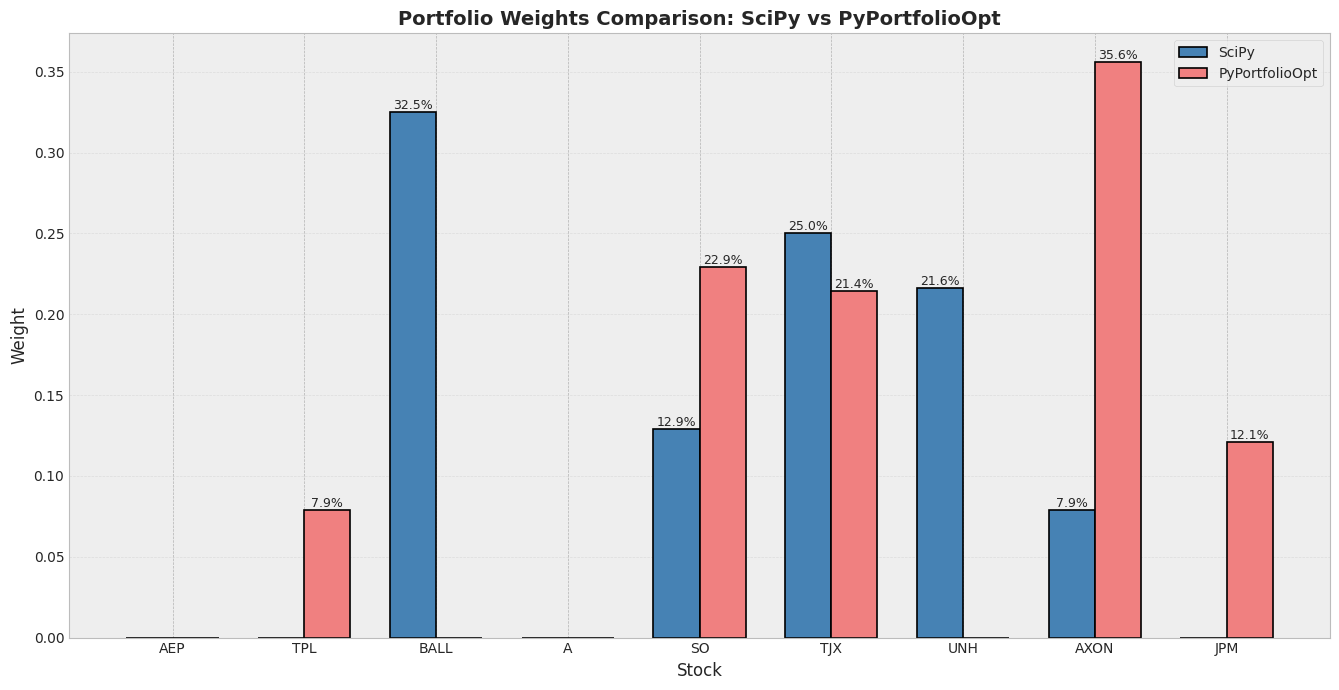

In [44]:
plot_weights_comparison(scipy_weights, pypfopt_weights)

## 10. Optimal Portfolio Summary Statistics

In [45]:
def create_detailed_summary(stocks, scipy_weights, pypfopt_weights, log_returns):
    """Create detailed summary with individual stock statistics and weights"""
    pypfopt_weights_array = np.array([pypfopt_weights.get(stock, 0) for stock in stocks])
    
    summary_data = {
        'Stock': stocks,
        'SciPy Weight': [f'{x:.5f}' for x in scipy_weights], #scipy_weights, 
        'PyPortfolioOpt Weight': pypfopt_weights_array,
        'Annual Return': log_returns.mean() * TRADING_DAYS,
        'Annual Volatility': log_returns.std() * np.sqrt(TRADING_DAYS),
        'Sharpe Ratio': (log_returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (log_returns.std() * np.sqrt(TRADING_DAYS))
    }
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('PyPortfolioOpt Weight', ascending=False)
    
    return summary_df

In [46]:
detailed_summary = create_detailed_summary(STOCKS, scipy_weights, pypfopt_weights, log_returns)
print('\n' + '=' * 100)
print('DETAILED SUMMARY: INDIVIDUAL STOCK STATISTICS WITH OPTIMAL WEIGHTS')
print('=' * 100)
print(detailed_summary.to_string(index=False))
print('=' * 100)


DETAILED SUMMARY: INDIVIDUAL STOCK STATISTICS WITH OPTIMAL WEIGHTS
Stock SciPy Weight  PyPortfolioOpt Weight  Annual Return  Annual Volatility  Sharpe Ratio
 AXON      0.07880                0.35599       0.240191           0.498218      0.409842
   SO      0.12927                0.22939       0.195261           0.298846      0.532921
  TJX      0.25042                0.21447       0.135842           0.239654      0.416608
  JPM      0.00000                0.12125       0.059081           0.329570      0.070035
  TPL      0.00000                0.07890       0.100368           0.228481      0.281719
  AEP      0.00000                0.00000       0.113012           0.293208      0.262653
 BALL      0.32535                0.00000       0.370824           0.492174      0.680296
    A      0.00000                0.00000       0.033227           0.308095     -0.009000
  UNH      0.21616                0.00000       0.192183           0.286005      0.546086


#### Github Reference:

- https://github.com/aldodec/Monte-Carlo-Portfolio-Allocation/tree/master
- https://pyportfolioopt.readthedocs.io/en/latest/